# Instance Segmentation

In this tutorial, you will learn:
- the basic structure of Mask R-CNN.
- to perform inference with a MMDetection detector.
- to train a new instance segmentation model with a new dataset.

Let's start!

<a href="https://colab.research.google.com/drive/11MqMCyF_V7Rkw6b9CCShGfNTP59OJ905?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

If you are running the tutorial files on the colab platform or a new virtual environment, please run the following code first to configure the runtime environment.
```python
!pip install -U openmim
!mim install "mmengine>=0.7.0"
!mim install "mmcv>=2.0.0rc4"

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .
```

In [12]:
# %cd mmdetection

/Users/candyliu/Desktop/imaterialist_checkpoint/mmdetection


In [7]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [13]:
# !pip install -U openmim
# !mim install "mmengine>=0.7.0"
# !mim install "mmcv>=2.0.0rc4"

In [4]:
import os
import numpy as np
import mmcv
import matplotlib.pyplot as plt
import mmengine
import pandas as pd
from pprint import pprint
import json
from pycocotools.coco import COCO

In [2]:
# Check Pytorch installation
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print("mmdetection:",mmdet.__version__)

# Check mmcv installation
import mmcv
print("mmcv:",mmcv.__version__)

# Check mmengine installation
import mmengine
print("mmengine:",mmengine.__version__)


torch version: 2.0.0 cuda: False
mmdetection: 3.2.0
mmcv: 2.1.0
mmengine: 0.9.1


## Train a Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



In [30]:
! pwd

/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/mmdetection


In [31]:
%cd imaterialist

/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/mmdetection/imaterialist


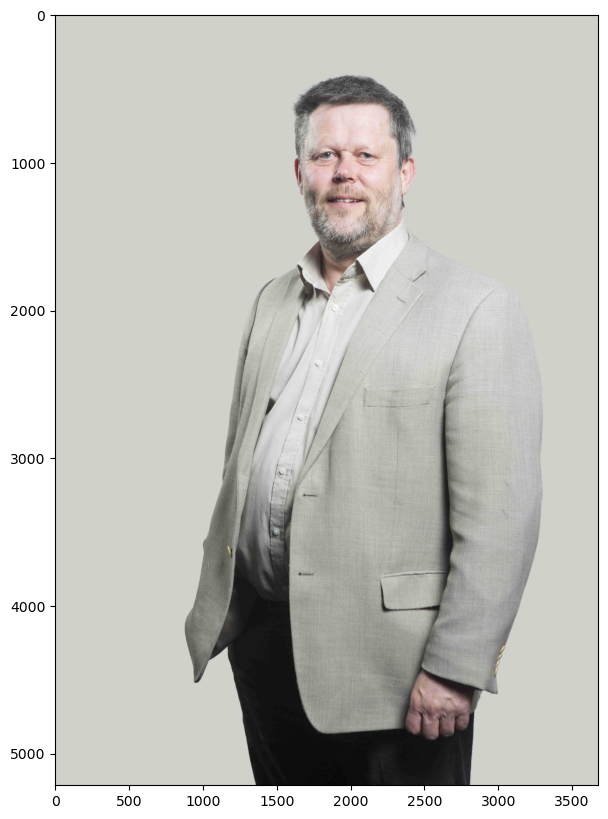

In [5]:
img = mmcv.imread('train/00000663ed1ff0c4e0132b9b9ac53f6e.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the annotation format into the COCO format. Then we can use implemented `COCODataset` to load the data and perform training and evaluation.
Let's take a look at the annotation json file.



In [39]:
# Read the CSV file
train_df = pd.read_csv('train.csv', nrows=10)

In [40]:
# number of unique images
uniq_images = train_df.ImageId.unique()
len(uniq_images)

2

In [41]:
# remove all the attributes after "_" in train_df['ClassId']
if "_" in train_df['ClassId'].to_string():
  train_df['ClassId'] = train_df['ClassId'].str.split('_').str.get(0)

# proprocessing: create new column ImageId
train_df = train_df.rename(columns={'ImageId': 'file_name'})
train_df['ImageId'] = pd.factorize(train_df['file_name'])[0]
train_df.head()

,file_name,EncodedPixels,Height,Width,ClassId,ImageId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,0
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,0
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,0
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,0


In [42]:
from pycocotools import mask as maskUtils

def rle_decoding(encoding, height, width):
    """
    Decodes RLE encoding into a binary mask and calculates the masked area and bbox.

    Parameters:
        encoding (str): RLE encoding as a space-separated string.
        height (int): Height of the image.
        width (int): Width of the image.

    Returns:
        mask (1d array): Decoded binary mask with shape (height, width).
        area (float): Total number of pixels in the mask.
        bbox (list): Bounding box coordinates [x, y, width, height].

    """
    # Remove space
    encoding = encoding.split()

    encoding = list(map(int, encoding))

    generated_1d_mask = np.zeros(width*height).astype(int)

    for j in range(len(encoding) // 2):
      generated_1d_mask[encoding[j * 2]:encoding[j * 2]+encoding[j * 2+1]] = 1

    mask = generated_1d_mask.reshape((width, height)).T.astype(int)
    area = float(np.sum(mask))

    # Find the coordinates of the foreground pixels
    coords = np.argwhere(mask == 1)

    # Calculate the bounding box
    x_min, y_min = np.min(coords, axis=0)
    x_max, y_max = np.max(coords, axis=0)
    bbox = [x_min, y_min, x_max - x_min + 1, y_max - y_min + 1]
    mask = mask.tolist()

    return mask, area, bbox

883261.0
[3924, 1163, 1290, 1677]


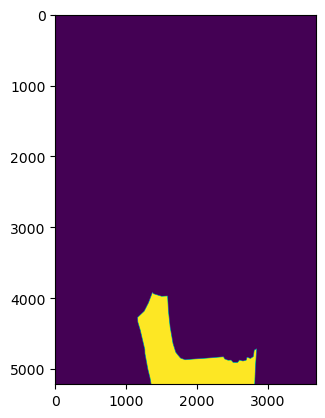

In [43]:
# Sample run of the function
encoding = train_df.iloc[0]['EncodedPixels']
height = train_df.iloc[0]['Height']
width = train_df.iloc[0]['Width']

generated_mask, area, bbox = rle_decoding(encoding, height, width)
# mask = generated_mask.reshape((width, height)).T
print(area)
print(bbox)

plt.imshow(generated_mask)

In [44]:
from tqdm import tqdm
# Create empty lists for the new columns
segmentation_list = []
area_list = []
bbox_list = []

for i in tqdm(range(len(train_df))):
    encoding = train_df.iloc[i]['EncodedPixels']
    height = train_df.iloc[i]['Height']
    width = train_df.iloc[i]['Width']
    mask, area, bbox = rle_decoding(encoding, height, width)

    # Append the values to the respective lists
    segmentation_list.append(mask)
    area_list.append(area)
    bbox_list.append(bbox)
    # if (i%100 == 0):
    #     print("current:", i)

# Assign the lists to the DataFrame columns
train_df['segmentation'] = segmentation_list
train_df['area'] = area_list
train_df['bbox'] = bbox_list

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


In [45]:
train_df['iscrowd'] = 0
train_df.drop('EncodedPixels', axis=1, inplace = True)
train_df.head(10)

,file_name,Height,Width,ClassId,ImageId,segmentation,area,bbox,iscrowd
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,6,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",883261.0,"[3924, 1163, 1290, 1677]",0
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",938874.0,"[1372, 1212, 2608, 1183]",0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,28,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",90430.0,"[1372, 1634, 521, 761]",0
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,31,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1501168.0,"[1828, 2474, 2776, 836]",0
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,32,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",61632.0,"[2510, 2078, 154, 500]",0
5,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,32,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",108026.0,"[3759, 2198, 271, 475]",0
6,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,31,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",65639.0,"[1780, 1133, 1384, 362]",0
7,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,29,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",494904.0,"[1438, 1231, 1950, 1293]",0
8,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5048335.0,"[1438, 875, 3435, 2435]",0
9,0000fe7c9191fba733c8a69cfaf962b7.jpg,2448,2448,33,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",28361.0,"[408, 899, 259, 609]",0


In [13]:
coco_base = { "info": {},
              "images": [],
              "annotations": [],
              "categories": []}

In [14]:
coco_base["info"] = {
    "year": 2019,
    "version": "1.0",
    "description": "The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.",
    "contributor": "iMaterialist Fashion Competition group",
    "url": "https://github.com/visipedia/imat_comp",
    "date_created": "2019-04-19 12:38:27.493919"
}

In [16]:
category_json = mmengine.load('/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/mmdetection/imaterialist/label_descriptions.json')
# category_json = mmengine.load('/Users/candyliu/Desktop/imaterialist_checkpoint/imaterialist/label_descriptions.json')

In [17]:
coco_base["categories"] = [
    {
        "id": category["id"],
        "name": category["name"],
        "supercategory": category["supercategory"]
    }
    for category in category_json["categories"]
]

In [18]:
# Remove duplicate rows based on the 'id' column
train_df_unique = train_df.drop_duplicates(subset='ImageId')

# Create a dictionary for each unique ID with its corresponding information
unique_ids = train_df_unique.apply(lambda row: {'id': row['ImageId'],
                                                'width': row['Width'],
                                                'height': row['Height'],
                                                'file_name': row['file_name']}, axis=1).tolist()

In [19]:
coco_base["images"] = unique_ids

In [27]:
annotation_df = train_df
annotation_df['id'] = range(len(annotation_df))
annotation_df = annotation_df.drop('file_name', axis=1)
annotation_df = annotation_df.drop('Height', axis = 1)
annotation_df = annotation_df.drop('Width', axis = 1)
annotation_df = annotation_df.rename(columns={'ClassId': 'category_id'})
annotation_df = annotation_df.rename(columns={'ImageId': 'image_id'})
annotation_df.head(10)

NameError: name 'train_df' is not defined

In [21]:
annotation_list = annotation_df.to_dict(orient='records')

# Assign parsed JSON object to coco_base["annotations"]
coco_base["annotations"] = annotation_list

In [32]:
# Convert the list of dictionaries to a JSON string
annotation_json = pd.DataFrame(annotation_list).to_json(orient='records')

# Save the JSON string to a files
with open('/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/mmdetection/imaterialist/annotation.json', 'w') as f:
    f.write(annotation_json)

In [33]:
# output_path = '/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/imaterialist/coco_base.json'
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

out_file = open('/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/imaterialist/coco_base10.json','w')
json.dump(coco_base, out_file, cls=NpEncoder)
out_file.close()

According to the above observation, each single image has a corresponding annotation containing keys `filename` and `regions` that are necessary for training.
We need to read annotations of each image and convert them into COCO format as below:

```python
{
    "images": [image],
    "annotations": [annotation],
    "categories": [category]
}


image = {
    "id": int,
    "width": int,
    "height": int,
    "file_name": str,
}

annotation = {
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height],
    "iscrowd": 0 or 1,
}

categories = [{
    "id": int,
    "name": str,
    "supercategory": str,
}]
```
**Note**: We only list the necessary keys for training, as shown above. For a full COCO format, please see [here](https://cocodataset.org/#format-data).

Checking the label corresponding to the instance split ID after the data format conversion is complete

In [23]:
# Path to load the COCO annotation file
annotation_file = '/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/imaterialist/coco_base.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

loading annotations into memory...
Done (t=3791.14s)
creating index...
index created!
Category ID: 0, Category Name: shirt, blouse
Category ID: 1, Category Name: top, t-shirt, sweatshirt
Category ID: 2, Category Name: sweater
Category ID: 3, Category Name: cardigan
Category ID: 4, Category Name: jacket
Category ID: 5, Category Name: vest
Category ID: 6, Category Name: pants
Category ID: 7, Category Name: shorts
Category ID: 8, Category Name: skirt
Category ID: 9, Category Name: coat
Category ID: 10, Category Name: dress
Category ID: 11, Category Name: jumpsuit
Category ID: 12, Category Name: cape
Category ID: 13, Category Name: glasses
Category ID: 14, Category Name: hat
Category ID: 15, Category Name: headband, head covering, hair accessory
Category ID: 16, Category Name: tie
Category ID: 17, Category Name: glove
Category ID: 18, Category Name: watch
Category ID: 19, Category Name: belt
Category ID: 20, Category Name: leg warmer
Category ID: 21, Category Name: tights, stockings
Catego

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [23]:
%cd ..

/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/mmdetection


In [3]:
from mmengine import Config
cfg = Config.fromfile('./configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py')

Given a config that trains a Mask R-CNN on COCO dataset, we need to modify some values to use it for training on the balloon dataset.

In [5]:
category_json = mmengine.load('/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/mmdetection/imaterialist/label_descriptions.json')
class_name = [category["name"] for category in category_json["categories"]]

class_name = tuple(class_name)
print(len(class_name))
print(type(class_name))

46
<class 'tuple'>


In [6]:
import random

# Generate 46 unique RGB color codes
color_codes = set()

while len(color_codes) < 46:
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    color_codes.add((red, green, blue))

color_codes = list(color_codes)

In [26]:
color_codes

[(49, 180, 125),
 (200, 104, 232),
 (98, 222, 164),
 (166, 42, 168),
 (98, 202, 76),
 (176, 118, 111),
 (234, 31, 221),
 (31, 234, 204),
 (195, 232, 77),
 (131, 62, 12),
 (243, 188, 210),
 (54, 27, 103),
 (255, 242, 250),
 (193, 116, 77),
 (33, 225, 38),
 (78, 152, 3),
 (57, 224, 116),
 (7, 193, 107),
 (176, 172, 243),
 (138, 41, 117),
 (234, 57, 221),
 (181, 248, 0),
 (85, 229, 8),
 (123, 13, 78),
 (76, 196, 150),
 (202, 255, 168),
 (134, 176, 245),
 (169, 82, 37),
 (227, 144, 255),
 (86, 5, 39),
 (61, 164, 69),
 (112, 21, 248),
 (174, 30, 220),
 (25, 104, 27),
 (117, 123, 175),
 (20, 15, 193),
 (41, 180, 69),
 (141, 83, 179),
 (49, 75, 18),
 (200, 116, 103),
 (28, 79, 222),
 (113, 30, 9),
 (163, 66, 81),
 (57, 175, 121),
 (181, 3, 88),
 (246, 120, 19)]

In [7]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': class_name,
    'palette': color_codes
}

# Modify dataset type and path
cfg.data_root = '/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/mmdetection/imaterialist'

cfg.train_dataloader.dataset.ann_file = 'coco_base10.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'coco_base10.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'train/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'coco_base10.json'
# cfg.test_evaluator = cfg.val_evaluators

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 46
cfg.model.roi_head.mask_head.num_classes = 46

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './milestone'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 1

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
# cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'./configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_apparel_milestone.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [8]:
!python tools/train.py {config}

11/17 00:50:43 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: darwin
    Python: 3.9.17 (main, Jul  5 2023, 16:17:03) [Clang 14.0.6 ]
    CUDA available: False
    numpy_random_seed: 1759422767
    GCC: Apple clang version 14.0.3 (clang-1403.0.22.14.1)
    PyTorch: 2.0.0
    PyTorch compiling details: PyTorch built with:
  - GCC 4.2
  - C++ Version: 201703
  - clang 13.1.6
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201811
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: NO AVX
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CXX_COMPILER=/Applications/Xcode_13.3.1.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/clang++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -Wno

### Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the original Mask R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layers of the pre-trained Mask R-CNN for classification and regression have different weight shape and are not used. The pre-trained weights of mask prediction layer `mask_head.conv_logits` also does not matches the current model and is not used due to similar reason.

Third, after training, the detector is evaluated by the default COCO-style evaluation. The results show that the detector achieves 79.6 bbox AP and 81.5 mask AP on the val dataset, not bad!

 We can also check the tensorboard to see the curves.

In [59]:
# %pip install tensorboard  -i https://mirrors.ustc.edu.cn/pypi/web/simple

In [9]:
# load tensorboard in jupyter notebook
%load_ext tensorboard

In [10]:
# see curves in tensorboard
# if you see <IPython.core.display.HTML object> please run it again
%tensorboard --logdir milestone/

Reusing TensorBoard on port 6006 (pid 8752), started 7 days, 3:29:05 ago. (Use '!kill 8752' to kill it.)

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [22]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('/Users/Chloe/Desktop/Uni/2023_Fall/COMP4471/project/mmdetection/imaterialist/train/0000fe7c9191fba733c8a69cfaf962b7.jpg',channel_order='rgb')
checkpoint_file = 'milestone/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: milestone/epoch_12.pth
<DetDataSample(

    META INFORMATION
    scale_factor: (0.32679738562091504, 0.32679738562091504)
    ori_shape: (2448, 2448)
    img_shape: (800, 800)
    img_path: None
    batch_input_shape: (800, 800)
    pad_shape: (800, 800)
    img_id: 0

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            scores: tensor([0.0545])
            bboxes: tensor([[1055.1174,  357.1318, 1382.7349,  855.3277]])
            labels: tensor([0])
            masks: tensor([[[False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False],
                         ...,
                         [False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False],
           

In [23]:
from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

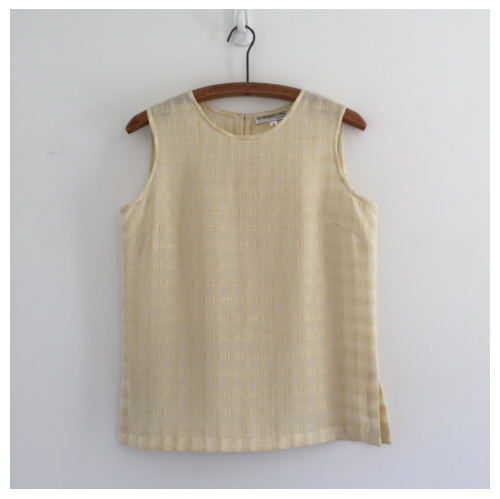

In [24]:
# show the results
visualizer.add_datasample(
    'result',
    img,
    data_sample=new_result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

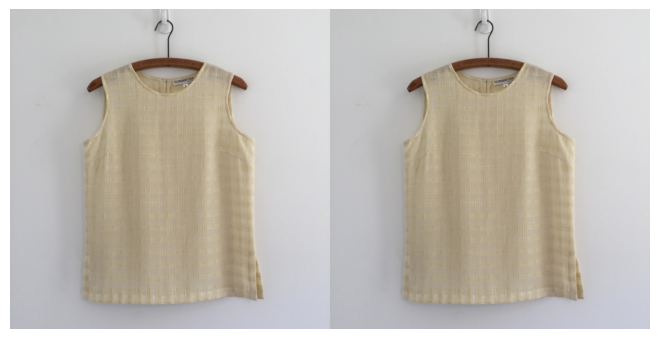

In [25]:
from mmengine.visualization import Visualizer
# get built visualizer
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=True,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)
visualizer_now.show()

## What to Do Next?

So far, we have learnt how to test and train Mask R-CNN. To further explore the segmentation task, you could do several other things as shown below:

- Try cascade methods, e.g., [Cascade Mask R-CNN](https://github.com/open-mmlab/mmdetection/tree/master/configs/cascade_rcnn) and [HTC](https://github.com/open-mmlab/mmdetection/tree/master/configs/htc) in [MMDetection model zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/en/model_zoo.md). They are powerful detectors that are ranked high in many benchmarks, e.g., COCO dataset.
- Try single-stage methods, e.g., [K-Net](https://github.com/ZwwWayne/K-Net) and [Dense-RepPoints](https://github.com/justimyhxu/Dense-RepPoints). These two algorithms are based on MMDetection. Box-free instance segmentation is a new trend in the instance segmentation community.
- Try semantic segmentation. Semantic segmentation is also a popular task with wide applications. You can explore [MMSegmentation](https://github.com/open-mmlab/mmsegmentation/); we also provide a [colab tutorial](https://github.com/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb) for semantic segmentation using MMSegmentation.
